In [4]:
import numpy as np
import mne
import os
from utils.loader import unicorn_fs
from utils.feature_extraction import extract_features
from utils.load_dataset import load_dataset, generate_samples
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from utils.validation import plot_confusion_matrix
from sklearn.metrics import f1_score, accuracy_score


mne.set_log_level(verbose='ERROR', return_old_level=False, add_frames=None)

%matplotlib inline
#matplotlib.use("Qt5Agg")


dataset_type = 'playing_listening'
path_dataset = os.path.join('data/dataset/dataset_04_04_2024_OSCAR', dataset_type)
labels = ['relax', 'excited']

### Preprocessing

1. Read Data
2. Generate Samples 
3. Extract Features

In [5]:
# Read dataset and generate samples
dataset = load_dataset(path_dataset, labels)
eeg_raw_baseline = dataset['baseline']
eeg_raw_class_0 = dataset[labels[0]]
eeg_raw_class_1 = dataset[labels[1]]

window_duration = 4 # seconds
window_size = window_duration * unicorn_fs # samples
window_overlap = 0.875 # percentage

print(f'\n{dataset_type} - baseline')
eeg_samples_baseline = generate_samples(eeg_raw_baseline, window_size, window_overlap)
print(f'\n{dataset_type} - {labels[0]}')
eeg_samples_class_0 = generate_samples(eeg_raw_class_0, window_size, window_overlap)
print(f'\n{dataset_type} - {labels[1]}')
eeg_samples_class_1 = generate_samples(eeg_raw_class_1, window_size, window_overlap)
print()

# Extract features
features_class_0, baseline = extract_features(eeg_samples_baseline, eeg_samples_class_0, baseline = None)
features_class_1, _ = extract_features(eeg_samples_baseline, eeg_samples_class_1, baseline)

print(f'Features shape: {features_class_0.shape}')

Loading file: data/dataset/dataset_04_04_2024_OSCAR\playing_listening\relax\song_playing_listening_relax.csv
Loading file: data/dataset/dataset_04_04_2024_OSCAR\playing_listening\excited\song_playing_listening_excited.csv
Loading file: data/dataset/dataset_04_04_2024_OSCAR\playing_listening\baseline\baseline_playing_listening_excited.csv

playing_listening - baseline
Sample dimension: (1000, 8)
Number of samples: 222

playing_listening - relax
Sample dimension: (1000, 8)
Number of samples: 462

playing_listening - excited
Sample dimension: (1000, 8)
Number of samples: 462

Extracting bands from sample: 222/222
Extracting bands from sample: 462/462
Extracting bands from sample: 462/462
Features shape: (462, 40)


#### Classification

(924, 40) (924,)
(739, 40) (185, 40) (739,) (185,)
Accuracy: 1.00 F1 Score: 1.00


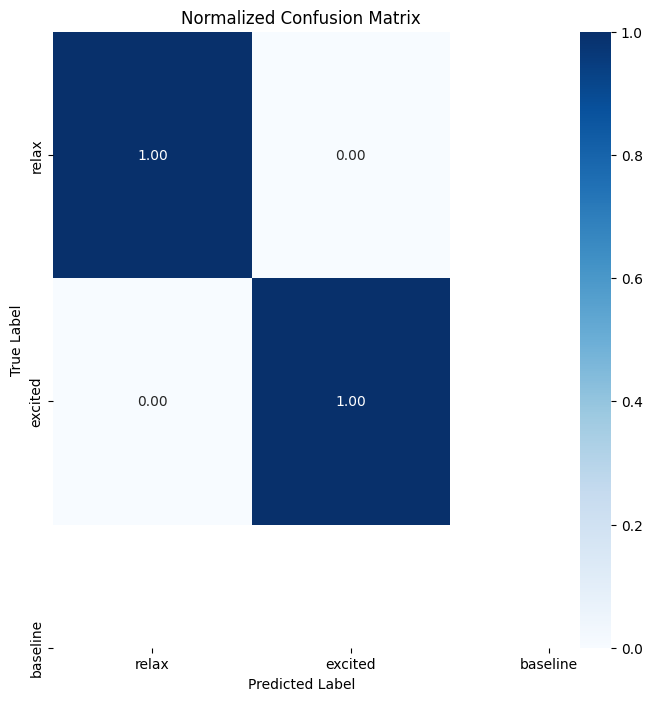

In [6]:
X = np.vstack((features_class_0, features_class_1))
y = np.hstack((np.zeros(len(features_class_0)), np.ones(len(features_class_1))))

print(X.shape, y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

# Apply LDA
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

# # Save the model
# outfile = 'models/lda_model.pkl'
# with open(outfile, 'wb') as pickle_file:
#     pickle.dump(lda_model, pickle_file)


# Make predictions on the test set
y_pred = lda_model.predict(X_test)
y_pred_proba = lda_model.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Accuracy: {accuracy:.2f} F1 Score: {f1:.2f}')
plot_confusion_matrix(y_test, y_pred, classes=labels, normalize=True)